# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи
- Выбранные предобученные веса 
- Полученные метрики

**Затем:**
- Глубина разведочного анализа
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

In [1]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-05-30 20:39:29--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa.7’

eng.testa.7         100%[===================>] 807.63K  --.-KB/s    in 0.01s   

2021-05-30 20:39:29 (62.8 MB/s) - ‘eng.testa.7’ saved [827012/827012]

--2021-05-30 20:39:29--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plai

In [2]:
! pip install transformers

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from transformers import BertForTokenClassification, BertTokenizer

from keras.preprocessing.sequence import pad_sequences

from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from sklearn.metrics import classification_report

import pandas as pd

In [4]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 980183.93it/s]


In [5]:
def get_label_distribution(labels: List[List[str]]):
  labels = [label \
            for labels_per_sent in labels \
            for label in labels_per_sent]
  return Counter(labels)

In [6]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

Train distribution


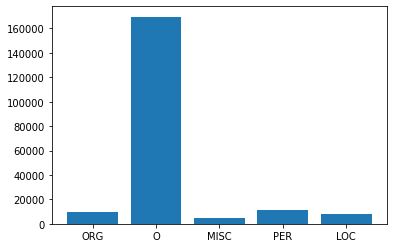

Valid distribution


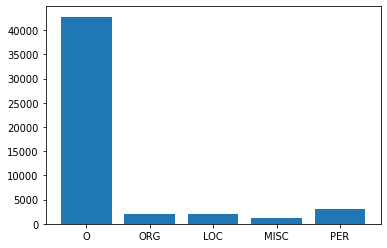

In [7]:
def visualize_distr(data: Counter):
  labels = list(data.keys())
  plt.bar(x=labels, height=list(data.values()))
  plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

Train distribution without 'O' 


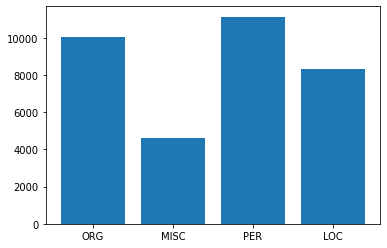

Valid distribution without 'O' 


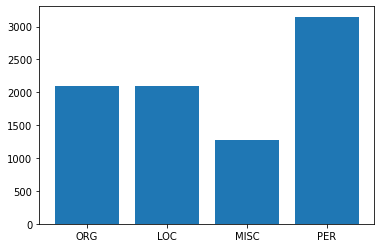

In [8]:
print("Train distribution without 'O' ")
visualize_distr({key:train_distribution[key] \
                 for key in train_distribution.keys() \
                 if key in ['LOC','ORG','MISC','PER']})
print("Valid distribution without 'O' ")
visualize_distr({key:valid_distribution[key] \
                 for key in valid_distribution.keys() \
                 if key in ['LOC','ORG','MISC','PER']})

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Так как максимальная длина последовательности в предобученной модели BERT равна 512, проверим максимальную длину последовательности в наших данных.

In [10]:
max_len = max([len(sen) for sen in train['sentences']])
top5_len = sorted([len(sen) for sen in train['sentences']])[-5:]

print('Самое длинное предложение:')
print(max_len)
print()
print('Топ 5 длин предложений:')
print(top5_len)

Самое длинное предложение:
113

Топ 5 длин предложений:
[62, 62, 67, 78, 113]


In [11]:
print('Топ 5 длин предложений в валидационной выборке:')
sorted([len(sen) for sen in valid['sentences']])[-5:]

Топ 5 длин предложений в валидационной выборке:


[83, 91, 93, 105, 109]

Токенизируем предложения в соответствии с найденной максимальной длиной предложения.

In [12]:
train['sentences'] = [tokenizer.convert_tokens_to_ids(sen) \
                      for sen in train['sentences']]
train['sentences'] = pad_sequences(train['sentences'],
                          maxlen=max_len, dtype="long", value=0.0,
                          truncating="post", padding="post")

valid['sentences'] = [tokenizer.convert_tokens_to_ids(sen) \
                      for sen in valid['sentences']]
valid['sentences'] = pad_sequences(valid['sentences'],
                          maxlen=max_len, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [13]:
label_to_index = {lab:i for i,lab in enumerate(train_distribution.keys())}

train['labels_per_sent'] = pad_sequences([[label_to_index[lab] \
                                           for lab in labs] \
                                          for labs in train['labels_per_sent']],
                          maxlen=max_len, dtype="long", value=label_to_index['O'],
                          truncating="post", padding="post")


valid['labels_per_sent'] = pad_sequences([[label_to_index[lab] \
                                           for lab in labs] \
                                          for labs in valid['labels_per_sent']],
                          maxlen=max_len, dtype="long", value=label_to_index['O'],
                          truncating="post", padding="post")


In [14]:
train['sentences'] = torch.tensor(train['sentences'])
valid['sentences'] = torch.tensor(valid['sentences'])

train['labels_per_sent'] = torch.tensor(train['labels_per_sent'])
valid['labels_per_sent'] = torch.tensor(valid['labels_per_sent'])


In [15]:
class NERDataset(Dataset):

  def __init__(self, data):
    self.sentences = data['sentences']
    self.labels = data['labels_per_sent']

  def __getitem__(self, index):
    return self.sentences[index], self.labels[index]

  def __len__(self):
    return len(self.sentences)

train_dataset = NERDataset(train)
valid_dataset = NERDataset(valid)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

В качестве модели возьмем предобученный BERT.

In [17]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label_to_index),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model = model.to(device)

In [20]:
index_to_label = {label_to_index[k]:k for k in label_to_index.keys()}

def transform_logits(predictions: List[torch.tensor]):
  pred = predictions.numpy().argmax(axis=2)
  return [[index_to_label[pr] \
           for pr in prlist] \
          for prlist in pred]

def transform_target(target_labels: List[torch.tensor]):
  return [[index_to_label[tr] \
           for tr in trlist] \
          for trlist in target_labels.numpy()]



In [21]:
def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
  gold_labels = [l for l_per_sent in gold_labels_per_sentence \
                 for k in l_per_sent \
                 for l in k]
  predict_labels = [l for l_per_sent in predict_labels_per_sentence \
                    for k in l_per_sent \
                    for l in k]
  print(classification_report(gold_labels, predict_labels))

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [23]:
losses = {"train_losses": [], "valid_losses": []}
average_losses = {"train_losses": [], "valid_losses": []}
epochs = 4

for epoch in range(epochs):
  print(f"Start epoch #{epoch}")
  model.train()
  total_train_loss = 0
  for train_batch in train_dataloader:

    # print(train_batch)
    # train_batch = torch.as_tensor(train_batch)
    # [print(device) for t in train_batch]
    train_batch = tuple(t.to(device) for t in train_batch)
    # train_batch = train_batch.to(device)
    out = model(train_batch[0], labels=train_batch[1])
    loss = out[0]
    optimizer.zero_grad()
    # print(loss)
    # print(logits)
    total_train_loss += loss.item()
    losses["train_losses"].append(loss.item())
    loss.backward()
    optimizer.step()
    
    # ...

  
  predict_labels, gold_labels = [], []

  model.eval()
  total_valid_loss = 0
  for valid_batch in valid_dataloader:

    # valid_batch = valid_batch.to(device)
    valid_batch = tuple(t.to(device) for t in valid_batch)
    with torch.no_grad():
      out = model(valid_batch[0], labels=valid_batch[1])
    losses["valid_losses"].append(out[0].item())
    total_valid_loss += out[0].item()
    logits = out[1].detach().cpu()
    label_ids = valid_batch[1].to('cpu')
    gold_labels.append(transform_target(label_ids))
    predict_labels.append(transform_logits(logits))
    # ...

  average_losses['train_losses'].append(total_train_loss/len(train['sentences']))
  average_losses['valid_losses'].append(total_train_loss/len(valid['sentences']))

  count_metrics(gold_labels, predict_labels)

  scheduler.step()
  
  print(f"End epoch #{epoch}")



Start epoch #0
              precision    recall  f1-score   support

         LOC       0.89      0.86      0.88      2094
        MISC       0.88      0.66      0.76      1268
           O       1.00      1.00      1.00    358647
         ORG       0.91      0.81      0.85      2092
         PER       0.92      0.92      0.92      3149

    accuracy                           1.00    367250
   macro avg       0.92      0.85      0.88    367250
weighted avg       1.00      1.00      1.00    367250

End epoch #0
Start epoch #1
              precision    recall  f1-score   support

         LOC       0.90      0.88      0.89      2094
        MISC       0.92      0.70      0.80      1268
           O       1.00      1.00      1.00    358647
         ORG       0.92      0.84      0.88      2092
         PER       0.91      0.95      0.93      3149

    accuracy                           1.00    367250
   macro avg       0.93      0.87      0.90    367250
weighted avg       1.00      1.00 

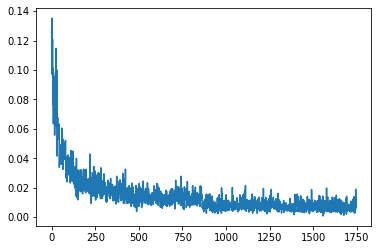

In [24]:
plt.plot(losses['train_losses'][10:])

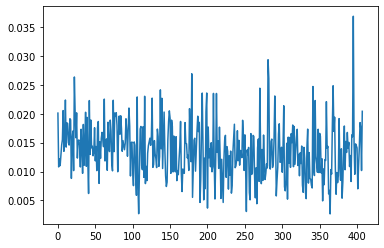

In [25]:
plt.plot(losses['valid_losses'])

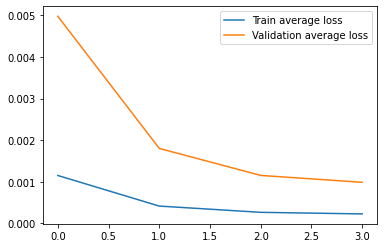

In [26]:
plt.plot(average_losses['train_losses'], label='Train average loss')
plt.plot(average_losses['valid_losses'], label='Validation average loss')
plt.legend()